<a href="https://colab.research.google.com/drive/1ufRR76yywyDtqddXz_MhcHIrpg5ww_II?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By [Ibrahim Sobh](https://www.linkedin.com/in/ibrahim-sobh-phd-8681757/)


# DRL: REINFORCE

![alt text](https://miro.medium.com/max/1200/1*LnQ5sRu-tJmlvRWmDsdSvw.gif)

## Introduction 
- **Value** based methods:  Optimal Value Function (Q) -> Optimal Policy
- **Policy** based methods: directly get the optimal policy without Value Function 

**[Cart Pole](https://gym.openai.com/envs/CartPole-v0/) Env.** 
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by **applying a force of +1 or -1** to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A **reward of +1** is provided for every timestep that the pole remains upright. The **episode ends** when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center. 

- Large state space: Cart position and velocity, Pole angle and velocity at tip
- NN takes state as input (4 values) and outputs probability distribution over action (2 actions: left or right)
- Train the NN $\theta$ to approximate the optimal policy via interaction with the env. to maximize the expected return $J$ (Agent's goal).
- Find $\theta$ that maximizes $J(\theta)$

As a result, the agent starts to learn the proper action per state and masters the task. 

## Policy Gradient

- **Policy based methods**: directly get the optimal policy without Value Function
- **Policy Gradient methods**: Estimate the best weights by gradient ascent

Definitions: 
- Trajectory (state - action sequence) $\tau$: $s_0,a_0,s_1,a_1, ... , s_H,a_H,s_{H+1}$
- Return corresponding to a trajectory:  $R(\tau) = r_1 + r_2 + .... + r_H + r_{H+1}$

**Goal**: maxmize the expected reurun: The agent experinces trajectories yield high return
-  Expected return $U(\theta) = \sum_{\tau} P(\tau;\theta)R(\tau) $
  - The weighted average (by probability of a trajectory $P(\tau;\theta)$ the depends of the wights $\theta$ of a neural nework) of all possible values that the return $R(\tau)$ can take.

One way to determine the value of $\theta$ that maximizes this function is through gradient ascent. 

$\theta := \theta + \alpha \nabla_{\theta} U(\theta) $ 

## REINFORCE

- **Problem**: To compute the exact value of the gradient $\nabla_{\theta} U(\theta)$ , we have to consider every possible trajectory! 

- **Solution**: just sample few trajectories using the policy and use these trajectories only to estimate the gradient.   

Steps:
- Loop
 - Use policy $\pi_{\theta}$ to collect $m$ trajectories $\tau^1, \tau^2, ... \tau^m$
  - Use the trajectories to estimate the gradient $\nabla_{\theta} U(\theta)$
  - Update the weights of the policy $\theta := \theta + \alpha \nabla_{\theta} U(\theta) $


Intuition 
- Increase the probability of state action pair $\pi_{\theta}(a_t,s_t)$ if win $R(\tau)$
- Decrease the probability of state action pair $\pi_{\theta}(a_t,s_t)$ if lose $R(\tau)$ 



## Install

In [0]:
!pip install pyvirtualdisplay 
!apt-get install -y xvfb python-opengl ffmpeg
!pip install gym
!pip install box2d-py
#!pip install pyglet==1.3.2
!pip install pyglet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl xvfb
0 upgraded, 2 newly installed, 0 to remove and 25 not upgraded.
Need to get 1,280 kB of archives.
After this operation, 7,682 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.3 [783 kB]
Fetched 1,280 kB in 3s (410 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 145113 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpa

In [0]:
!pip install tensorboardX

     |████████████████████████████████| 204kB 34.4MB/s 


## Imports

In [0]:
%tensorflow_version 2.x
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
from collections import deque
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from pyvirtualdisplay import Display
from tensorboardX import SummaryWriter


TensorFlow 2.x selected.


## Video

In [0]:
display = Display(visible=0, size=(1400, 900))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

## Policy and Env.

In [0]:
env = gym.make('CartPole-v0')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

observation space: Box(4,)
action space: Discrete(2)
cuda:0


In [0]:
policy = Policy().to(device)
print(policy)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

Policy(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=2, bias=True)
)


## Vanilla Reinforce

In [0]:
# Vanilla Reinforce 
def Reinforce_Vanilla(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    avg_scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()

        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        avg_scores.append(np.mean(scores[-10:]))

        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = sum(policy_loss)
        
        optimizer.zero_grad() 
        policy_loss.backward() 
        optimizer.step() 

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores, avg_scores
    
scores, avg_scores = Reinforce_Vanilla()

Episode 100	Average Score: 34.47
Episode 200	Average Score: 66.26
Episode 300	Average Score: 87.82
Episode 400	Average Score: 72.83
Episode 500	Average Score: 172.00
Episode 600	Average Score: 160.65
Episode 700	Average Score: 167.15
Environment solved in 691 episodes!	Average Score: 196.69


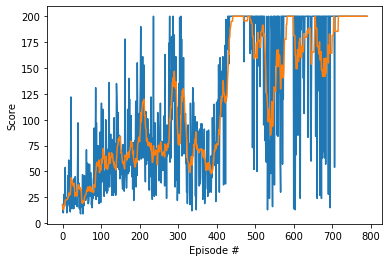

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(avg_scores)), avg_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Reinforce multiple trajectories

In [0]:
del policy
del optimizer
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

# Reinforce multiple trajectories
def Reinforce_multitraj(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100, traj = 7):
    scores_deque = deque(maxlen=100)
    scores = []
    avg_scores = []
    for i_episode in range(1, n_episodes+1):
        
        R_list = []
        saved_log_probs_list = []
        # loop over trajectories 
        for t in range(traj):
          saved_log_probs = []
          rewards = []
          state = env.reset()

          for t in range(max_t):
              action, log_prob = policy.act(state)
              saved_log_probs.append(log_prob)
              state, reward, done, _ = env.step(action)
              rewards.append(reward)
              if done:
                  break 
          
          scores_deque.append(sum(rewards))
          scores.append(sum(rewards))
          avg_scores.append(np.mean(scores[-10:]))
        
          discounts = [gamma**i for i in range(len(rewards)+1)]
          R = sum([a*b for a,b in zip(discounts, rewards)])
          R_list.append(R)
          saved_log_probs_list.append(saved_log_probs)
          
        Ri = torch.tensor(R_list)
        R_all_traj = []
        for rs, probs in zip(R_list, saved_log_probs_list):
          rs = (rs - Ri.mean()) / (Ri.std() + 1e-6)
          policy_loss = []
          for log_prob in probs:         
            policy_loss.append(-log_prob * rs)
          policy_loss = sum(policy_loss)
          R_all_traj.append(policy_loss)
        
        policy_loss_all_traj = sum(R_all_traj)/traj
        
        optimizer.zero_grad() 
        policy_loss_all_traj.backward() 
        optimizer.step() 

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} trajectories!\tAverage Score: {:.2f}'.format(len(scores)-100, np.mean(scores_deque)))
            break
        
    return scores, avg_scores

scores, avg_scores = Reinforce_multitraj()

Environment solved in 593 trajectories!	Average Score: 195.26


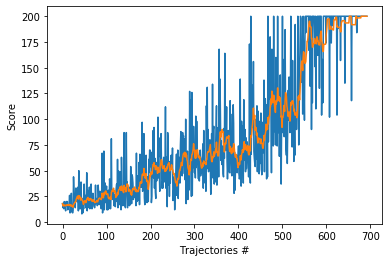

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(avg_scores)), avg_scores)
plt.ylabel('Score')
plt.xlabel('Trajectories #')
plt.show()

## Reinforce Future

In [0]:
# Reinforce Future discounted rewards 
del policy
del optimizer
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def Reinforce_Future(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    avg_scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()

        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        avg_scores.append(np.mean(scores[-10:]))

        # https://medium.com/@thechrisyoon/deriving-policy-gradients-and-implementing-reinforce-f887949bd63
        discounted_rewards = []
        for t in range(len(rewards)):
          Gt = 0 
          pwr = 0
          for r in rewards[t:]:
              Gt = Gt + gamma**pwr * r
              pwr = pwr + 1
          discounted_rewards.append(Gt)

        # normalize discounted rewards
        discounted_rewards = torch.tensor(discounted_rewards)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-6) 

        # print('discounted_rewards (Gt)', discounted_rewards)
        policy_loss = []
        for log_prob, Gt in zip(saved_log_probs, discounted_rewards):
          policy_loss.append(-log_prob * Gt)
        
       
        # policy_loss = torch.cat(policy_loss).sum()
        policy_loss = sum(policy_loss)
        
        optimizer.zero_grad() # optimizer.zero_grad() clears gradients in the optimizer. It’s important to call this before loss.backward().
        policy_loss.backward() # computes the gradient of the policy_loss.
        optimizer.step() # optimizer.step updates the value of w using the gradient.
        

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores, avg_scores
    
scores, avg_scores = Reinforce_Future()

Episode 100	Average Score: 48.11
Episode 200	Average Score: 147.39
Episode 300	Average Score: 186.36
Episode 400	Average Score: 180.83
Episode 500	Average Score: 140.10
Episode 600	Average Score: 171.12
Episode 700	Average Score: 123.93
Environment solved in 667 episodes!	Average Score: 195.34


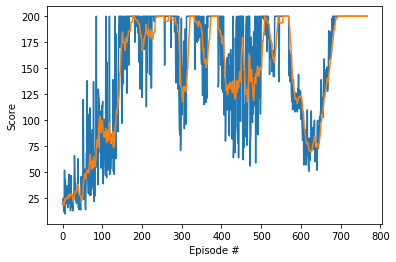

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(avg_scores)), avg_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Play

In [0]:
env = wrap_env(env)

In [0]:
action_list = []
state = env.reset()
with torch.no_grad():
  for t in range(200):
      action, _ = policy.act(state)
      action_list.append(action)
      env.render()
      state, reward, done, _ = env.step(action)
      if done: 
        break;
            
env.close()
show_video()

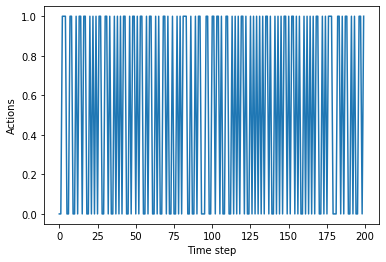

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(action_list)), action_list)
plt.ylabel('Actions')
plt.xlabel('Time step')
plt.show()